```
python 3.6, Matlab 2018b, PyTorch 1.4.0
```

### Libraries

In [105]:
%matplotlib inline
import numpy as np
import os
from glob import glob
# import cv2
import skimage.io as skio
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from Utilities import patchify, BlockSet
from PIL import Image
# from sklearn.feature_extraction import image

### Load data

In [106]:
refDir = r'/media/banikr2/DATA/Diesel_block/4_refocus'
segDir = r'/media/banikr2/DATA/Diesel_block/5_segmented'
mskDir = r'/media/banikr2/DATA/Diesel_block/6_binarymask'
refFiles = sorted(glob(os.path.join(refDir, '*.tif')))#.sort()
segFiles = sorted(glob(os.path.join(segDir, '*.tif')))#.sort()
mskFiles = sorted(glob(os.path.join(mskDir, '*.png')))

Same number of image slices:

In [107]:
len(refFiles), len(segFiles), len(mskFiles)

(294, 294, 294)

In [129]:
im = Image.open(refFiles[20]).convert('RGB')
sg = Image.open(segFiles[20]).convert('RGB')
mk = Image.open(mskFiles[20]).convert('L') # L --> Load image as grayscale mode. 

``` works but PIL chosen
im = skio.imread(refFiles[20], plugin="tifffile")
sg = skio.imread(segFiles[20], plugin="tifffile")
mk = skio.imread(mskFiles[20])
```

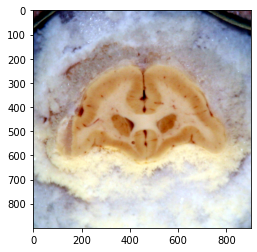

In [130]:
plt.imshow(im)
# plt.imshow(mk)

In [131]:
imarray = np.array(im) 
sgarray = np.array(sg)
mkarray = np.array(mk)

In [132]:
imarray.dtype, imarray.shape, sgarray.dtype, sgarray.shape, mkarray.dtype, mkarray.shape

(dtype('uint8'),
 (900, 900, 3),
 dtype('uint8'),
 (900, 900, 3),
 dtype('uint8'),
 (900, 900))

In [133]:
np.unique(mk)

array([  0, 255], dtype=uint8)

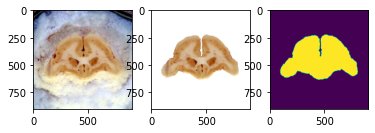

In [11]:
plt.subplot(131)
plt.imshow(im)
# plt.axis("off")
plt.subplot(132)
plt.imshow(sg)
# plt.axis("off")
plt.subplot(133)
plt.imshow(mk)
plt.show()

``` matlab
>> whos img21
  Name         Size                 Bytes  Class    Attributes

  img21      900x900x3            2430000  uint8  

>> whos seg21
  Name        Size                 Bytes  Class    Attributes
  seg21      900x900x3            2430000  uint8              
```

ground truth should be converted to a binary mask?<br> $0$ --> non-brain part of the slice <br> $1$ --> brain part of the slice

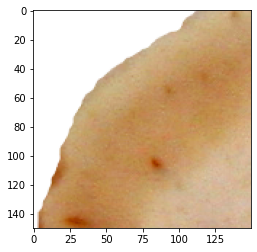

In [12]:
sg_chunk = sg[250:400,200:350,:]
plt.imshow(sg_chunk)

Convert to grayscale `rgb2gray` in *Matlab*

|<p>|<p>|<p>|<p>|
|:-:|:-:|:-:|:-:|
| <img src="../Images/rgb_21.jpg" style="width: 200px;"/> _slice #020_ |<img src="../Images/seg_21.jpg" style="width: 200px;"/> |<img src="../Images/grayscale_21.jpg" style="width: 200px;"/> |<img src="../Images/binarymask_21.jpg" style="width: 200px;"/>  |
| <img src="../Images/rgb_201.jpg" style="width: 200px;"/> _slice #200_|<img src="../Images/seg_201.jpg" style="width: 200px;"/>|<img src="../Images/grayscale_201.jpg" style="width: 200px;"/> |<img src="../Images/binarymask_201.jpg" style="width: 200px;"/>  |
|_refocused image(RGB)_|_segmented image(RGB)_|_grayscaled_|_binary mask_|

non-brain pixels were removed by `regionprops` _Matlab_

|<p>|<p>|
|:-:|:-:|
| <img src="../Images/binarymask_190.png" style="width: 200px;"/> |<img src="../Images/binarybrainmask_190.png" style="width: 200px;"/> |

patch size : `128,128,3` or `224,224,3` <br>
The following code should cover the whole image/mask given patchsize and stepsize

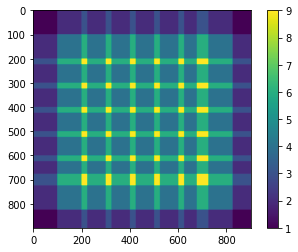

In [62]:
patchsize = [224, 224]
stepsize = [100, 100]
i, m = patchify(im,mk,patchsize,stepsize,plotovermat=True)

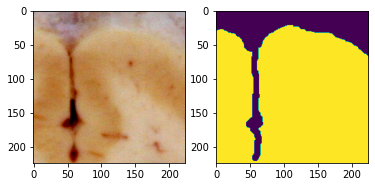

In [15]:
plt.subplot(121)
plt.imshow(i[20,...])
# plt.show()
plt.subplot(122)
plt.imshow(m[20,...])
plt.show()

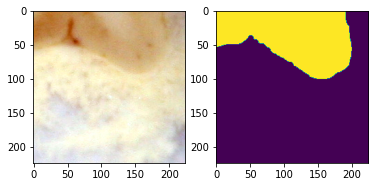

In [16]:
plt.subplot(121)
plt.imshow(i[46,...])
# plt.show()
plt.subplot(122)
plt.imshow(m[46,...])
plt.show()

In [17]:
i.shape, m.shape, i.dtype, m.dtype, len(i), m.size

((64, 224, 224, 3),
 (64, 224, 224),
 dtype('uint8'),
 dtype('uint8'),
 64,
 3211264)

### Dataset/DataLoader
``` code are in and imported from
Utilities.py
```

In [134]:
from Utilities import BlockSet
unitSet = BlockSet(refFiles, mskFiles)

In [135]:
refFiles, mskFiles

(['/media/banikr2/DATA/Diesel_block/4_refocus/100_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/103_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/106_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/109_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/10_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/112_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/115_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/118_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/121_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/124_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/127_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/130_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/133_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/136_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_refocus/139_refocus.tif',
  '/media/banikr2/DATA/Diesel_block/4_ref

In [140]:
# len(unitSet)
x,y = next(iter(unitSet))
# uniLoader = DataLoader(unitSet,batch_size=10,shuffle=True, num_workers=1)

StopIteration: 

In [104]:
image, seg = next(iter(uniLoader))

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f17ff72add8>>
Traceback (most recent call last):
  File "/home/banikr2/miniconda3/envs/block36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/banikr2/miniconda3/envs/block36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/banikr2/miniconda3/envs/block36/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/banikr2/miniconda3/envs/block36/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/banikr2/miniconda3/envs/block36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/banikr2/miniconda3/envs/block36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/banikr2/PycharmProjects/Blockface/Codes/Utilities.py", line 67, in __getitem__
    imP = np.transpose(imP, (1, 0, 4, 2, 3))
IndexError: index 64 is out of bounds for axis 1 with size 64


In [144]:
m.shape

(64, 224, 224)

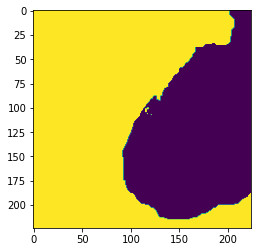

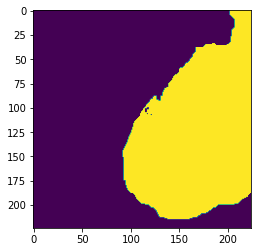

In [71]:
plt.imshow(mkout[0,32,...])
plt.show()
plt.imshow(mkout[1,32,...])
plt.show()

In [37]:
np.where(m==0)

(array([ 0,  0,  0, ..., 63, 63, 63]),
 array([  0,   0,   0, ..., 223, 223, 223]),
 array([  0,   1,   2, ..., 221, 222, 223]))

In [44]:
x.shape, y.shape

NameError: name 'x' is not defined

In [ ]:
trainLoader = DataLoader(unitSet, transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]) , 
                        )

Not needed
``` python
patches = torch.tensor(sg).unfold(0, 128, 10).unfold(1, 128, 10).unfold(2, 3, 3)
print(patches.shape)
plt.imshow(patches[31,35,0,...])
plt.imshow(patches_[17,...])
plt.show()
plt.imshow(mskpatches[17,...])
```

### ToDo:
1. ~~Remove isolated pixels outside brain.~~
2. ~~Create binary/target masks for all the slices and datastructure...~~
3. ~~Tiling for image and masks.~~
4. Dataset/DataLoader in pytorch.
5. Network architecture: start with U-Net?
6. Loss function(binary cross entropy or ?)

### Questions/doubt:
1. In Blockset(Dataset) normalize before patching? How do I normalize RGB? globally or locally? <br>
    -The mean and std values are usually calculated from all training images. Also you should pass them as normalized values, since `transforms.ToTensor()` will normalize your data so that the values are in the range [0, 1]. A division of the mean and std by 255. should be sufficient[2]. ImageNet mean and std[3] work quite well for normal images. 
 <br>   
2. How to validate the created binary masks? 
3. Save patches in a directory? or feed to the network from memory(_gradient accumulation_)
4. ~~There are small pixels scattered outside brain regions, do we need to remove those by erosion or other morphological operations?~~
 - ~~**caveats:** some slices have unit brain, some have two or three parts, _largest connected component_ may not work.~~

### Reference:
1. For normalization: https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6?u=ptrblck
2. Customized dataset for semantic segmentation: https://discuss.pytorch.org/t/how-make-customised-dataset-for-semantic-segmentation/30881/5
3. ImageNet: https://github.com/pytorch/examples/blob/91f230a13b95c6259e5cb22b6cef355de998cede/imagenet/main.py#L189